In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import save_npz, load_npz

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

from os.path import expanduser, join

from collections import Counter

import abs_tag_lib as at

## Obtain dataset

Let's first load the metadata archive into a panda dataframe (we can do this in one go since the size of the archive is not unbearable, although we are at the limit). To deal with it otherwise, we would have to stream the json file.

In [2]:
# path to metadata archive
home = expanduser("~")
path_archive = join(home,'Downloads/archive.zip')

# load the archive in pandas dataframe
df = pd.read_json(path_archive,lines=True)

We are here interested in the high energy physics category of the arXiv, especially the theoretical one. We select the items within this category, and the columns we are interested in.

In [3]:
# The category we are interested in and the columns we want to keep
category = 'hep-th'
relevant_columns = ['id','title','abstract','update_date','authors_parsed']

# Cleaning up the dataframe
relevant_items = df['categories'].apply(lambda item : category in item)

df_hep = df[relevant_items][relevant_columns].copy()
df_hep.drop_duplicates(subset='id',inplace=True)
df_hep.reset_index(drop=True,inplace=True)

# save cleaned dataframe 
df_hep.to_pickle('./dataset/dataset_hep.pkl')

## Cleaning title and abstracts



In [2]:
df_hep = pd.read_pickle('./dataset/dataset_hep.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed
140495,solv-int/9912009,Quantum Lax Pair From Yang-Baxter Equations,We show explicitly how to construct the quan...,2010-11-16,"[[Lima-Santos, A., ]]"
140496,solv-int/9912010,Real forms of the complex twisted N=2 supersym...,Three nonequivalent real forms of the comple...,2017-02-08,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]"
140497,solv-int/9912012,Whitham-Toda Hierarchy in the Laplacian Growth...,The Laplacian growth problem in the limit of...,2010-05-27,"[[Mineev-Weinstein, Mark, ], [Zabrodin, Anton, ]]"
140498,solv-int/9912015,Vector NLS hierarchy solitons revisited: dress...,We discuss some algebraic aspects of the int...,2007-05-23,"[[Blas, Harold, ]]"
140499,supr-con/9510001,The string model of the Cooper pair in the ani...,The analogy between the Cooper pair in high ...,2009-10-28,"[[Dzhunushaliev, V. D., ]]"


We are now going to clean the abstracts and titles, that is,
- removing latex equations
- removing punctuation
- setting the words in lowercase
- remove stopwords
- lemmatize the words

In [3]:
# Our choice of lemmatizer and stopwords
wnl = WordNetLemmatizer()
stpw = stopwords.words('english')

# Cleaning the title and abstacts
df_hep['clean_title'] = df_hep['title'].apply(at.clean_text_lemmatize,args=(wnl,stpw))
df_hep['clean_abstract'] = df_hep['abstract'].apply(at.clean_text_lemmatize,args=(wnl,stpw))

Let's check what are the most common words,

In [19]:
words = np.hstack((df_hep['clean_title'],df_hep['clean_abstract']))
words = np.concatenate(words)

full_vocabulary = Counter(words)
full_vocabulary.most_common(10)

[('theory', 171243),
 ('field', 129456),
 ('model', 111266),
 ('quantum', 70959),
 ('gauge', 65488),
 ('non', 63298),
 ('space', 59049),
 ('2', 57439),
 ('string', 56244),
 ('two', 55016)]

And the total number of unique words,

In [20]:
len(full_vocabulary.keys())

58271

We can get rid of non-frequent words in the vocabulary, since they will probably not be useful, and in this way we should reduce the size of the vocabulary (the features, since we will use TF-IDF vectorization later on).

In [23]:
# words with a count higher than min_count are kept in the vocabulary
min_count = 5

vocabulary = [word for word in full_vocabulary.keys() if full_vocabulary[word] > min_count]

The total number of words in the vocabulary is then,

In [25]:
len(vocabulary)

18241

Let's now remove the words that are not in the vocabulary from the title and abstacts,

In [29]:
in_vocabulary_words = lambda item : [word for word in item if word in vocabulary]

df_hep['clean_title'] = df_hep['clean_title'].apply(in_vocabulary_words)
df_hep['clean_abstract'] = df_hep['clean_abstract'].apply(in_vocabulary_words)

We can check if the transformation performed above has empited any of the titles of abstracts, and what is the distributions of lenghts,

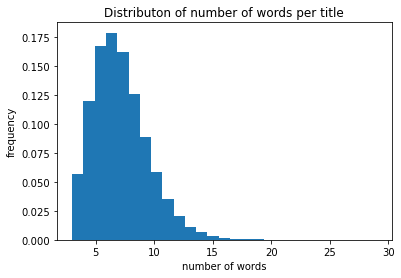

Range for # words in title = 3 - 29


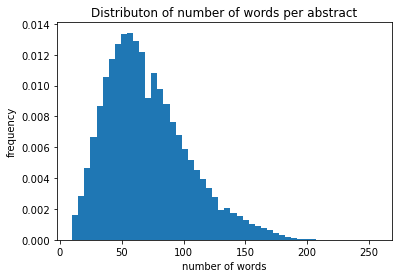

Range for # words in abstract = 10 - 256


In [52]:
title_lengths = df_hep['clean_title'].apply(len).to_numpy()
abstract_lengths = df_hep['clean_abstract'].apply(len).to_numpy()

plt.hist(title_lengths,bins=27,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per title')
plt.show()

print('Range for # words in title = {} - {}'.format(min(title_lengths),
                                                    max(title_lengths)
                                                   )
     )

plt.hist(abstract_lengths,bins=50,density=True)
plt.xlabel('number of words')
plt.ylabel('frequency')
plt.title('Distributon of number of words per abstract')
plt.show()

print('Range for # words in abstract = {} - {}'.format(min(abstract_lengths),
                                                       max(abstract_lengths)
                                                      )
     )

We can get rid of those entries with a title with less that 3 words, and an abstract of less than 10 words, I think.

In [47]:
min_count_title = 3
min_count_abstract = 10

bool_keep = np.logical_and(title_lengths>=min_count_title, abstract_lengths>=min_count_abstract)
df_hep = df_hep[bool_keep].reset_index(drop=True)

And finally save the cleaned dataset,

In [49]:
df_hep.to_pickle('./dataset/dataset_hep_cleaned.pkl')

## Pre-processing title and abstracts

We can now pre-process the data. We are going to apply TF-IDF on the joint title and abstract.

In [30]:
df_hep = pd.read_pickle('./dataset/dataset_hep_cleaned.pkl')
df_hep.tail()

,id,title,abstract,update_date,authors_parsed,clean_title,clean_abstract
137383,solv-int/9912009,Quantum Lax Pair From Yang-Baxter Equations,We show explicitly how to construct the quan...,2010-11-16,"[[Lima-Santos, A., ]]","[quantum, lax, pair, yang, baxter, equation]","[show, explicitly, construct, quantum, lax, pa..."
137384,solv-int/9912010,Real forms of the complex twisted N=2 supersym...,Three nonequivalent real forms of the comple...,2017-02-08,"[[Lechtenfeld, Olaf, ], [Sorin, Alexander, ]]","[real, form, complex, twisted, n, 2, supersymm...","[three, nonequivalent, real, form, complex, tw..."
137385,solv-int/9912012,Whitham-Toda Hierarchy in the Laplacian Growth...,The Laplacian growth problem in the limit of...,2010-05-27,"[[Mineev-Weinstein, Mark, ], [Zabrodin, Anton, ]]","[whitham, toda, hierarchy, laplacian, growth, ...","[laplacian, growth, problem, limit, zero, surf..."
137386,solv-int/9912015,Vector NLS hierarchy solitons revisited: dress...,We discuss some algebraic aspects of the int...,2007-05-23,"[[Blas, Harold, ]]","[vector, nls, hierarchy, soliton, revisited, d...","[discus, algebraic, aspect, integrable, vector..."
137387,supr-con/9510001,The string model of the Cooper pair in the ani...,The analogy between the Cooper pair in high ...,2009-10-28,"[[Dzhunushaliev, V. D., ]]","[string, model, cooper, pair, anisotropic, sup...","[analogy, cooper, pair, high, temperature, sup..."


In [34]:
full_corpus = (df_hep['clean_title']+df_hep['clean_abstract']).to_numpy()

# This is needed since we did all the pre-processing outside sklearn
tokens_to_string = np.vectorize(lambda word_list: ' '.join(word_list))

full_corpus = tokens_to_string(full_corpus)

# Let's create the vectorized matrix (while splitting the corpus back into tokens)
vectorizer = TfidfVectorizer(analyzer=str.split)
X = vectorizer.fit_transform(full_corpus)

features = np.array(vectorizer.get_feature_names())

print('The dataset is composed of {} observations and {} features'.format(*X.shape))

The dataset is composed of 137388 observations and 18238 features


In [37]:
save_npz('./dataset/vectorized/X',X)
np.save('./dataset/vectorized/features',features)

## Visualizing the data distribution

Before we start clustering, we'd be interested in checking if the data can indeed be divided into clear clusters. Since checking this in the vectors space we have embedded the features is not possible, we use Multi-Dimensional Scaling (the distance between entries is computed in the high-dimensional vector space, and the items are then represented in 2D while preserving the distance).

Since the number of items we have is too big for computing the similarity matrix and storing it, we sample part of the dataset and use MDS on this subset.

In [38]:
X = load_npz('./dataset/vectorized/X.npz')
features = np.load('./dataset/vectorized/features.npy',allow_pickle=True)

Let's visualize different subsets of X randomly sampled,

In [22]:
from numpy.random import default_rng
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

N,_ = X.shape
M = 1000

rng = default_rng(seed=8362)

index = rng.choice(N,size=M, replace=False)
sub_X = X[index]

In [23]:
mds = MDS(n_components=2, n_init=4, n_jobs=-1, dissimilarity='precomputed')

dist = pairwise_distances(sub_X,metric='cosine',n_jobs=-1)
sub_X_2D = mds.fit_transform(dist)

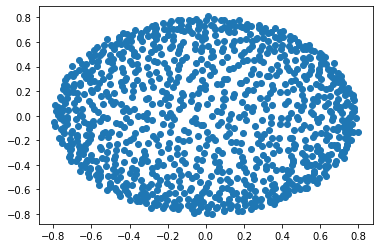

In [24]:
plt.scatter(*sub_X_2D.T)

## Clustering

In [25]:
N,_ = X.shape
M = 10000

rng = default_rng(seed=8362)

index = rng.choice(N,size=M, replace=False)
X = X[index]

In [26]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=1836)
kmeans.fit(X)

array([[6.94909757e-03, 0.00000000e+00, 2.16360687e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.37110902e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.52332246e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 4.51832761e-05, 3.41651474e-05],
       ...,
       [1.39674903e-02, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.49816291e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.38611462e-03, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.02437400e-03]])

In [36]:
for cluster in kmeans.cluster_centers_:
    relevant_features = cluster != 0
    
    cluster_features = features[relevant_features]
    cluster_importance = cluster[relevant_features]
    
    cluster_character = sorted(zip(cluster_features,cluster_importance),key=lambda x: x[1],reverse=True)
    
    print(cluster_character[:10])

[('inflation', 0.0769735761365939), ('model', 0.05763860188137659), ('dark', 0.05737140385573432), ('cosmological', 0.055680032252376), ('universe', 0.048485676654242395), ('scalar', 0.04476996882534064), ('field', 0.04451675281403921), ('energy', 0.04273399233442572), ('matter', 0.04039472140824373), ('scale', 0.03808468274854896)]
[('quantum', 0.15679619386902358), ('theory', 0.04311678446128473), ('gravity', 0.04224062431269942), ('field', 0.04045520571810873), ('classical', 0.0356128415540427), ('state', 0.031098940712660447), ('mechanic', 0.029161725297792238), ('space', 0.028977539206211857), ('system', 0.026776741663884704), ('time', 0.02547466034129284)]
[('model', 0.03228458605664048), ('theory', 0.02502768225388959), ('equation', 0.02402726104578675), ('field', 0.02381539928751184), ('function', 0.022094667773819972), ('solution', 0.021609916484819545), ('space', 0.019061868499279464), ('two', 0.01826098900922106), ('dimensional', 0.016980963887252606), ('non', 0.016436965206